In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:

# --- 1. Load Data ---

# Load the file names
# Make sure 'file_list.txt' is in the same directory or provide the full path
try:
    with open('file_list.txt', 'r', encoding='utf-8') as config_file:
        file_names = config_file.read().splitlines()
except FileNotFoundError:
    print("Error: 'file_list.txt' not found. Please ensure it exists.")
    exit() # Exit if the file list is missing

# Regex pattern to match the log entries
pattern = r'\[(.*?)\] (.*?): (.*)'

datalist = []
stream_count = 0
# Assuming 'data' subdirectory exists relative to the script location
data_dir = "data\\"

for file in file_names:
    full_path = data_dir + file
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                match = re.match(pattern, line)
                if match:
                    date_str, user, message = match.groups()
                    # Append raw data first, convert date later for efficiency
                    datalist.append([date_str, user, message, stream_count])
        stream_count += 1
    except FileNotFoundError:
        print(f"Warning: File '{full_path}' not found. Skipping.")
    except Exception as e:
        print(f"Error reading file '{full_path}': {e}")


# --- 2. Create DataFrame and Initial Processing ---

if not datalist:
    print("Error: No data was loaded. Exiting.")
    exit()

# Create a DataFrame
data = pd.DataFrame(datalist, columns=["date_str", "user", "message", "stream"])

# Convert 'date_str' to datetime format (handle potential errors)
data['date'] = pd.to_datetime(data['date_str'], errors='coerce')

# Drop rows where date conversion failed
original_rows = len(data)
data.dropna(subset=['date'], inplace=True)
if len(data) < original_rows:
    print(f"Warning: Dropped {original_rows - len(data)} rows due to invalid date format.")

# --- CHANGE 1: Create Year-Month Period and Month Number ---
# Create a unique identifier for each year-month combination (e.g., 2023-01, 2024-01)
data['year_month'] = data['date'].dt.to_period('M')
# Keep the month number separately for base color lookup
data['month'] = data['date'].dt.month


# --- 3. User Replacements / Cleaning ---
# (Using .loc for potentially better performance on large datasets)
replace_map = {
    "Banties1g": "banties_x",
    "banties1g": "banties_x",
    "chili_poe": "chili_con_bacon",
    "CHILI_POE": "chili_con_bacon",
    "chili_conbacon": "chili_con_bacon",
    "Wirelesss_": "W1r3lesss",
    "treklul": "trek44_",
    "ttrek_": "trek44_",
    "TriplesingleJ": "TripleSingleJames",
    "uwu_cougar": "uuccugr",
    "uuccugr_": "uuccugr",
    "stan_iv4": "StanIV4_"
}
data["user"] = data["user"].replace(replace_map)



C:\Users\Kardo\AppData\Local\Temp\ipykernel_5152\4048486870.py:58: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['date'].dt.to_period('M')


In [3]:
from collections import defaultdict

# Get all unique usernames
unique_users = data['user'].unique()

# Create a mapping from lowercase username to all variants

user_variants = defaultdict(set)
for user in unique_users:
    user_variants[user.lower()].add(user)

# Find usernames with different capitalization
duplicate_users = {k: v for k, v in user_variants.items() if len(v) > 1}

# Display the results
for lower, variants in duplicate_users.items():
    print(f"{lower}: {sorted(variants)}")

tilch: ['Tilch', 'tilch']
trizze: ['Trizze', 'trizze']
gyllenc: ['Gyllenc', 'gyllenc']
roomunder: ['ROOMUNDER', 'roomunder']
notbat: ['NOTBAT', 'notbat']
nurm1_0_0: ['NURM1_0_0', 'NuRM1_0_0']
iamconvinc3d: ['Iamconvinc3d', 'iamconvinc3d']
wisez__: ['wiseZ__', 'wisez__']
r4rrixd: ['R4RRIXD', 'r4rrixd']
obungakung: ['OBUNGAKUNG', 'obungakung']
chimphailpk: ['ChimpHailpk', 'chimphailpk']
xfrell1: ['Xfrell1', 'xfrell1']
lopilop1: ['Lopilop1', 'lopilop1']
trodainus: ['Trodainus', 'trodainus']
kavnera: ['KAVNERA', 'kavnera']
noxiex4charity12: ['Noxiex4Charity12', 'noxiex4charity12']
macbless: ['MacBless', 'macbless']
anos87w: ['Anos87w', 'anos87w']
vladyslav_h: ['VLADYSLAV_H', 'vladyslav_h']
ars_rugal: ['ARS_RUGAL', 'ars_rugal']
artemioni4: ['Artemioni4', 'artemioni4']
torst3ncs: ['tORST3NCS', 'tORST3Ncs']
adel5244: ['Adel5244', 'adel5244']
f1zzcsgo: ['F1ZZcsgo', 'f1zzcsgo']
bubrekht: ['BuBRekht', 'BuBrekht', 'bubrekht']
martimmendez: ['MartimMendeZ', 'martimmendez']
xvenumz_97: ['xVeNuMz_97

In [4]:
# Create a mapping from all variants to the canonical (sorted first) variant
variant_map = {}
for variants in duplicate_users.values():
    sorted_variants = sorted(variants)
    canonical = sorted_variants[0]
    for v in variants:
        variant_map[v] = canonical

# Replace usernames in 'user' column
data['user'] = data['user'].apply(lambda u: variant_map.get(u, u))

In [5]:
bots = ['StreamElements', 'Nightbot', 'AnAnonymousGifter', 'Fossabot']

subset_df = data[~data['user'].isin(bots)].reset_index(drop=True)

In [6]:


# Optional: User capitalization fixing logic (kept commented as in original)
# Extract all unique users from the other streams as a reference
#reference_users = set(data[data["stream"] != 302]["user"].unique())
# Extract users from stream 302
#stream_302_users = data[data["stream"] == 302]["user"]
# Create a mapping of lowercase to correct capitalization using the reference data
#user_mapping = {user.lower(): user for user in reference_users}
# Fix capitalization for users in stream 302
#fixed_users = stream_302_users.apply(lambda x: user_mapping.get(x.lower(), x))
# Count how many users needed to be fixed
#fix_count = (stream_302_users != fixed_users).sum()
# Update the data with fixed users
#data.loc[data["stream"] == 302, "user"] = fixed_users


# --- 4. Data Aggregation for Plotting ---

# Optional: Filtering logic (kept commented as in original)
# Group by stream and user to find single message users
#single_message_users = data.groupby(["stream", "user"]).size().reset_index(name="message_count")
#single_message_users = single_message_users[single_message_users["message_count"] == 1]
# Find users who appeared in multiple streams
#multi_stream_users = data.groupby("user")["stream"].nunique().reset_index(name="stream_count")
#multi_stream_users = multi_stream_users[multi_stream_users["stream_count"] > 1]
# Filter the data to include only relevant users
#result_users = single_message_users[single_message_users["user"].isin(multi_stream_users["user"])]
#data = data[data["user"].isin(result_users["user"])]

# Get the first stream for each user
first_stream = data.groupby('user')['stream'].min().reset_index()
first_stream.columns = ['user', 'first_stream']

# Merge to get the first stream info
data_with_first = pd.merge(data, first_stream, on='user', how='left') # Use left merge

# Group to get the stream statistics (count unique users per stream, grouped by their first appearance stream)
stream_stats = data_with_first.groupby(['stream', 'first_stream'])['user'].nunique().reset_index()

# Pivot the table for plotting (streams as rows, first_stream as columns)
try:
    pivot_table = stream_stats.pivot(index='stream', columns='first_stream', values='user').fillna(0)
except Exception as e:
     print(f"Error creating pivot table: {e}")
     print("Check if 'stream_stats' DataFrame is structured correctly.")
     # print(stream_stats.head()) # Optional: print head to debug
     exit()

if pivot_table.empty:
    print("Warning: Pivot table is empty. No data to plot.")
    # You might want to exit or handle this case depending on requirements
    # exit()


# --- 5. Color Generation Logic (Year-Month Aware) ---

# Define base colors for each month
base_color_map = {
    1: '#008B8B',   # Dark Cyan
    2: '#FF8C00',   # Dark Orange
    3: '#006400',   # Dark Green
    4: '#8B0000',   # Dark Red
    5: '#450145',   # Dark Purple
    6: '#00008B',   # Dark Blue
    7: '#808000',   # Olive
    8: '#006400',   # Dark Green
    9: '#8B4513',   # Dark Brown (SaddleBrown)
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'   # Dark Magenta
}


# Function to generate shades (updated for robustness)
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    if n_shades <= 0:
        return []
    try:
        # Ensure base_color is treated as RGB for manipulation
        color_rgb = mcolors.to_rgb(base_color)
    except ValueError:
        print(f"Warning: Invalid base color '{base_color}'. Using black as fallback.")
        color_rgb = mcolors.to_rgb('black')

    # Generate a lighter version of the base color (RGB only)
    light_color_rgb = [min(1, max(0, 1 - (1 - c) * (1 - lightness_factor))) for c in color_rgb]

    # Handle the case of n_shades=1 explicitly
    if n_shades == 1:
        return [mcolors.to_hex(color_rgb)] # Return hex color

    # Create colormap between base and light color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color_rgb, light_color_rgb], N=n_shades)

    # Generate hex colors from the colormap using normalized positions for smoother gradient
    # Using i / (n_shades - 1) gives points from 0.0 to 1.0 inclusive
    shades_rgba = [cmap(i / (n_shades - 1)) for i in range(n_shades)]
    return [mcolors.to_hex(c) for c in shades_rgba] # Convert to hex


# --- CHANGE 2: Group by Year-Month and Generate Colors ---

# Get the specific year-month for each stream (assuming one stream doesn't span months)
# Taking the first occurrence, assuming all messages in a stream have the same year-month
stream_year_months = data.groupby('stream')['year_month'].first()

# Create a dictionary to store the final color for each stream
stream_color_map = {}

# Get unique year-month periods sorted chronologically
unique_year_months = sorted(stream_year_months.dropna().unique()) # Drop NA just in case

# Iterate over each unique year-month period
for ym_period in unique_year_months:
    # Get the base month number (1-12) for this period
    base_month_num = ym_period.month
    base_color = base_color_map.get(base_month_num, '#808080') # Use gray as fallback

    # Get the stream IDs that occurred in this specific year-month
    # Ensure we compare with the period object
    streams_in_this_period = stream_year_months[stream_year_months == ym_period].index.tolist()
    n_streams_in_period = len(streams_in_this_period)

    # Generate shades specifically for the streams in this year-month
    shades = generate_shades(base_color, n_streams_in_period)

    # Assign a shade to each stream in the current year-month
    # Sort streams numerically for consistent shade assignment within the month
    streams_in_this_period.sort()
    for i, stream_id in enumerate(streams_in_this_period):
         if i < len(shades):
            stream_color_map[stream_id] = shades[i]
         else:
            # Fallback if something went wrong (e.g., n_streams=0 led to empty shades)
            print(f"Warning: Could not assign shade to stream {stream_id}. Using base color.")
            stream_color_map[stream_id] = base_color


# --- CHANGE 3: Create the final list based on the pivot table's index ---
# Ensure the colors are applied in the correct order corresponding to the pivot table rows (streams)
# Provide a default color for any stream in the pivot table index that might not have received a color
default_color = '#000000' # Black as default
sorted_color_list = []
for stream_id in pivot_table.index:
    color = stream_color_map.get(stream_id, default_color)
    sorted_color_list.append(color)
    if color == default_color and stream_id in stream_color_map:
         # This case should ideally not happen with the current logic, but good to check
         print(f"Info: Stream {stream_id} was in map but defaulted? Color: {stream_color_map.get(stream_id)}")
    elif color == default_color:
         print(f"Warning: Stream {stream_id} from pivot table index not found in stream_color_map. Assigning default color.")




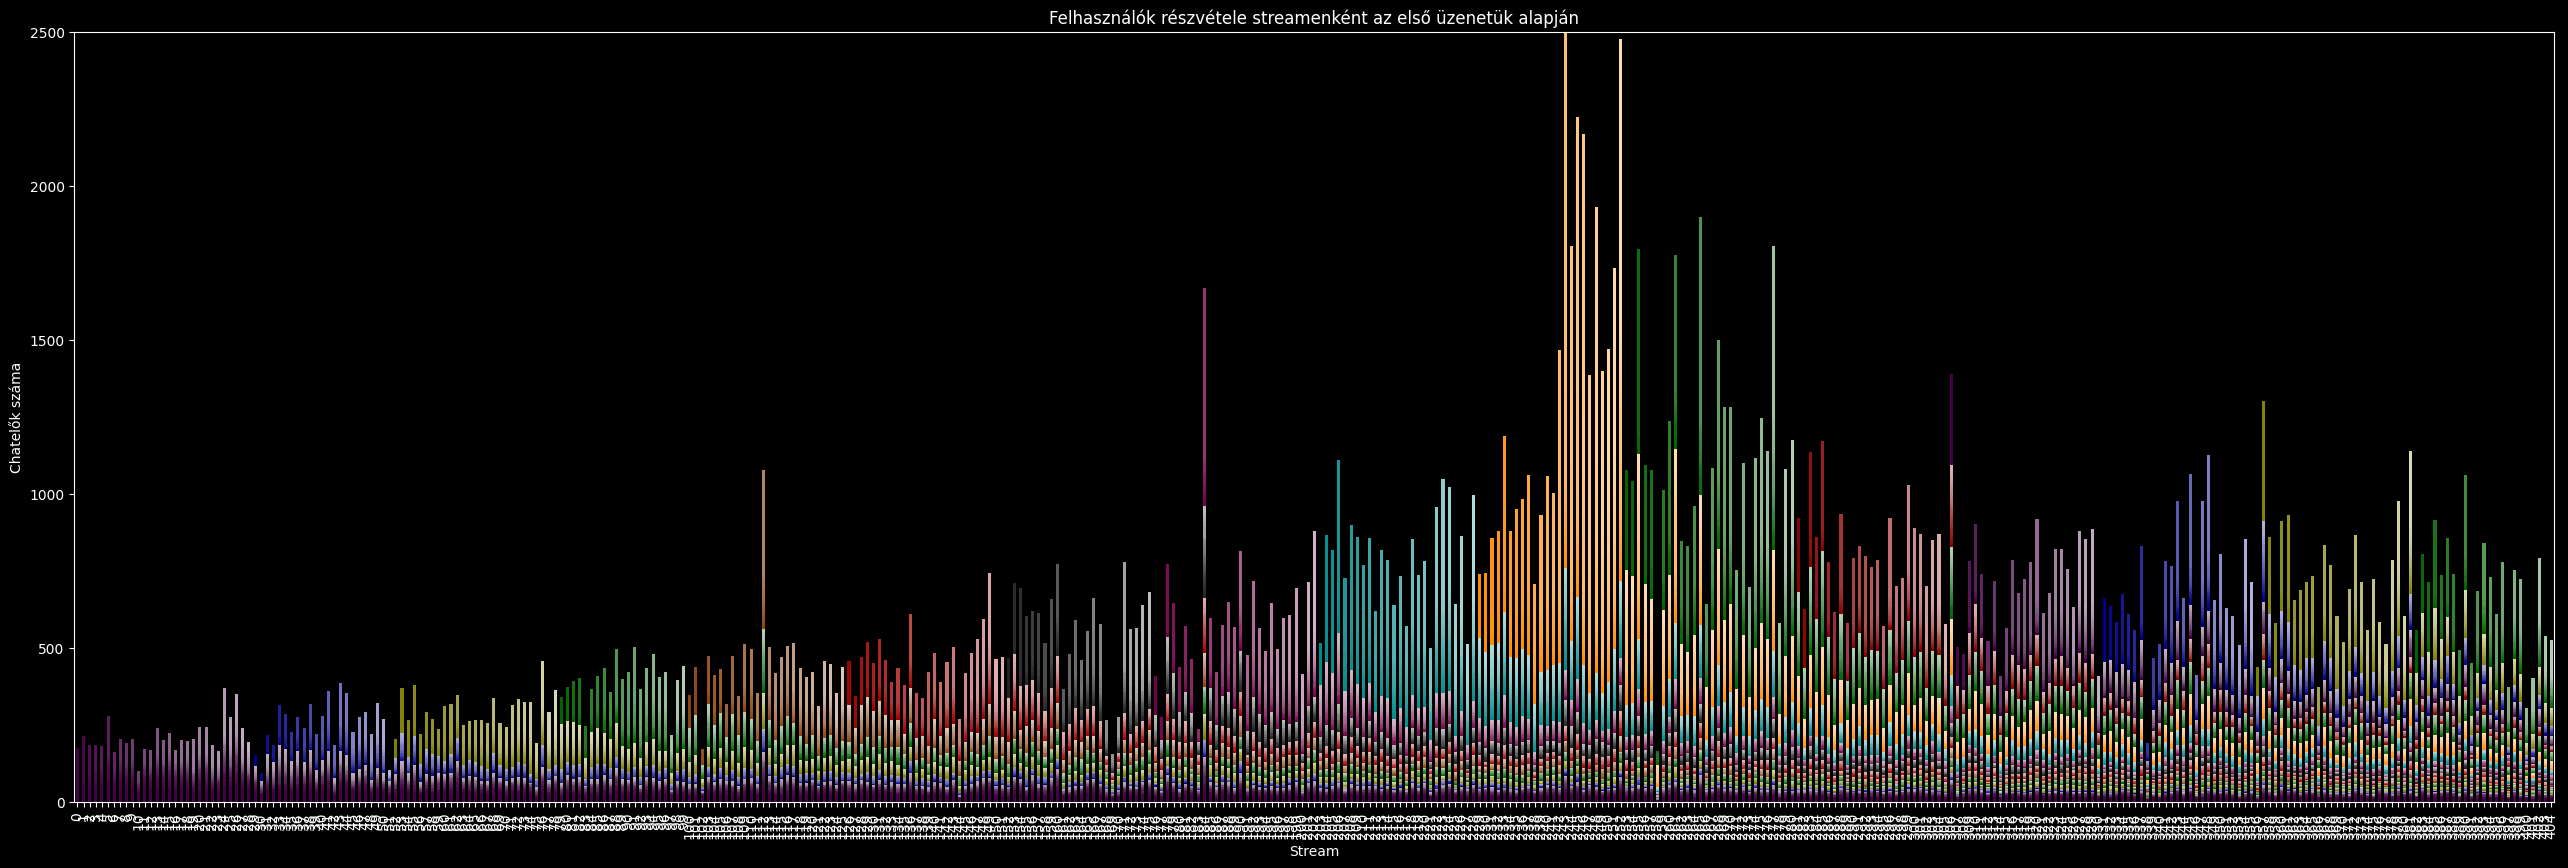

In [7]:
plt.style.use('dark_background')
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(32, 10), color=sorted_color_list, legend=False)
plt.title('Felhasználók részvétele streamenként az első üzenetük alapján')
plt.xlabel('Stream')
plt.ylabel('Chatelők száma')
plt.ylim(0, 2500)

plt.show()
#ax.set_ylim(0, 1500)  # Limit the y-axis range to cut off extreme values

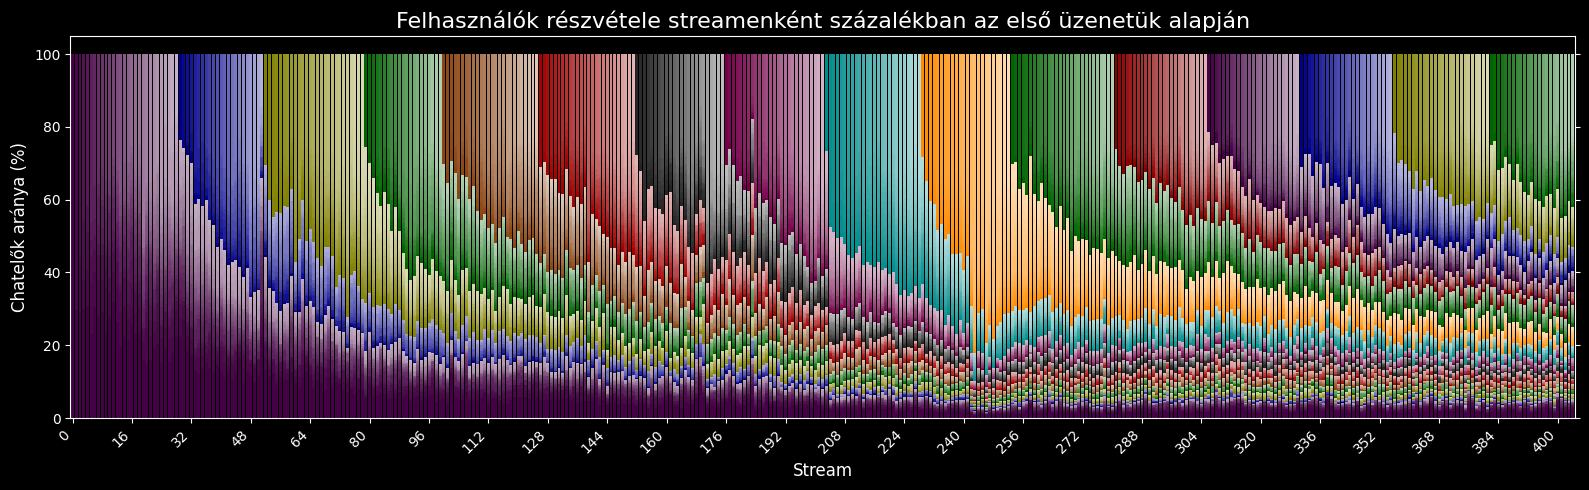

In [8]:
# --- Assume these are already calculated correctly from earlier parts ---
# stream_stats = data_with_first.groupby(['stream', 'first_stream'])['user'].nunique().reset_index()
# pivot_table = stream_stats.pivot(index='stream', columns='first_stream', values='user').fillna(0)
#
# --- Assume 'data' DataFrame exists with 'date', 'year_month', 'month' columns ---
# --- Assume 'base_color_map' dictionary exists ---
# --- Assume 'generate_shades' function exists and is correct ---

# Convert the counts to percentages (normalize by row total)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0).fillna(0) * 100 # Added fillna(0) in case a row sum is 0

# --- REPLACEMENT START: Corrected Year-Month Aware Color Generation ---

# Get the specific year-month for each stream (assuming one stream doesn't span months)
# Requires the 'data' DataFrame to have the 'year_month' column calculated earlier
stream_year_months = data.groupby('stream')['year_month'].first()

# Create a dictionary to store the final color for each stream
stream_color_map = {}

# Get unique year-month periods sorted chronologically
unique_year_months = sorted(stream_year_months.dropna().unique()) # Drop NA just in case

# Iterate over each unique year-month period
for ym_period in unique_year_months:
    # Get the base month number (1-12) for this period
    base_month_num = ym_period.month
    base_color = base_color_map.get(base_month_num, '#808080') # Use gray as fallback

    # Get the stream IDs that occurred in this specific year-month
    streams_in_this_period = stream_year_months[stream_year_months == ym_period].index.tolist()
    n_streams_in_period = len(streams_in_this_period)

    # Generate shades specifically for the streams in this year-month
    shades = generate_shades(base_color, n_streams_in_period)

    # Assign a shade to each stream in the current year-month
    # Sort streams numerically for consistent shade assignment within the month
    streams_in_this_period.sort()
    for i, stream_id in enumerate(streams_in_this_period):
         if i < len(shades):
            stream_color_map[stream_id] = shades[i]
         else:
            # Fallback if something went wrong
            # print(f"Warning: Could not assign shade to stream {stream_id} (percent plot). Using base color.") # Optional warning
            stream_color_map[stream_id] = base_color

# Ensure the colors are applied in the correct order based on the pivot table index
# Use the stream_color_map to look up the color for each stream in the percentage table's index
default_color = '#000000' # Black as default
sorted_color_list = []
for stream_id in pivot_table_percentage.index:
    color = stream_color_map.get(stream_id, default_color)
    sorted_color_list.append(color)
    # if color == default_color and stream_id not in stream_color_map: # Optional warning
    #     print(f"Warning: Stream {stream_id} from percentage pivot index not found in stream_color_map. Assigning default.")

# --- REPLACEMENT END ---


# --- Plotting Code (Uses the correctly generated sorted_color_list) ---
if not pivot_table_percentage.empty:
    # Check if the number of colors matches the number of bars (streams)
    if len(sorted_color_list) == len(pivot_table_percentage):
        plt.style.use('dark_background')
        ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, width=0.8, legend=False) # Adjusted size/width

        plt.title('Felhasználók részvétele streamenként százalékban az első üzenetük alapján', fontsize=16) # Participation % by First Message Stream
        plt.xlabel('Stream', fontsize=12)
        plt.ylabel('Chatelők aránya (%)', fontsize=12) # Chatter Proportion (%)
        ax.yaxis.set_ticks_position('both')

        # Improve x-axis labels if too many streams
        num_streams = len(pivot_table_percentage.index)
        if num_streams > 50: # Adjust threshold as needed
             tick_frequency = num_streams // 25 # Show label roughly every 25 streams
             ax.set_xticks(ax.get_xticks()[::tick_frequency])
             # Ensure labels match the selected ticks
             ax.set_xticklabels(pivot_table_percentage.index[::tick_frequency], rotation=45, ha='right')
        else:
             plt.xticks(rotation=45, ha='right')

        # Add percentage labels (optional, can be cluttered)
        # for c in ax.containers:
        #     labels = [f'{w:.1f}%' if (w := v.get_height()) > 5 else '' for v in c] # Show % only if > 5%
        #     ax.bar_label(c, labels=labels, label_type='center', fontsize=8, color='white', weight='bold')


        plt.tight_layout()
        plt.show()
    else:
        print("Error: Mismatch between number of colors generated and number of streams in percentage pivot table.")
        print(f"Colors: {len(sorted_color_list)}, Streams: {len(pivot_table_percentage.index)}")
else:
    print("Skipping percentage plot generation as the percentage pivot table is empty.")

In [9]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,400,401,402,403,404
stream,,,,,,,,,,,,,,,,,,,,,
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,29.577465,70.422535,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,29.189189,14.594595,56.216216,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,29.891304,8.152174,16.304348,45.652174,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,30.769231,9.890110,10.439560,7.142857,41.758242,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,3.583062,0.977199,0.325733,0.000000,0.000000,0.325733,0.0,0.000000,0.000000,0.651466,...,2.931596,0.977199,1.954397,2.605863,0.977199,18.566775,0.000000,0.000000,0.000000,0.000000
401,1.736973,0.496278,0.496278,0.000000,0.248139,0.744417,0.0,0.496278,0.000000,0.248139,...,1.488834,1.488834,0.744417,1.736973,1.736973,1.240695,26.550868,0.000000,0.000000,0.000000
402,1.896334,0.632111,0.379267,0.000000,0.000000,0.379267,0.0,0.126422,0.126422,0.379267,...,0.884956,1.264223,1.137800,1.137800,1.011378,0.505689,1.390645,26.675095,0.000000,0.000000


In [10]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,400,401,402,403,404
stream,,,,,,,,,,,,,,,,,,,,,
0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54.0,27.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55.0,15.0,30.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56.0,18.0,19.0,13.0,76.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,11.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,9.0,3.0,6.0,8.0,3.0,57.0,0.0,0.0,0.0,0.0
401,7.0,2.0,2.0,0.0,1.0,3.0,0.0,2.0,0.0,1.0,...,6.0,6.0,3.0,7.0,7.0,5.0,107.0,0.0,0.0,0.0
402,15.0,5.0,3.0,0.0,0.0,3.0,0.0,1.0,1.0,3.0,...,7.0,10.0,9.0,9.0,8.0,4.0,11.0,211.0,0.0,0.0


In [11]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')